# Hyperdimensional Computing (HDC) on MNIST: Key Intuition

## Introduction to MNIST
- **MNIST** is a classic dataset in machine learning, containing **28x28 grayscale images of handwritten digits (0–9)**.
- Each image is labeled with the correct digit.
- It is commonly used for **testing and learning image classification algorithms**.

## What is Hyperdimensional Computing (HDC)?
- HDC is an alternative to traditional neural networks for classification.
- Instead of learning weights and biases, HDC **encodes data into very high-dimensional vectors** (tens of thousands of dimensions).
- Each class (digit) is represented by a **centroid vector**, which is essentially the “average” vector of all training images of that class.

## How HDC Works Step-by-Step
1. **Encoding Images**
   - Each image is **flattened** into a 1D vector of pixels.
   - Each pixel is assigned:
     - A **position vector** (to remember where the pixel is in the image)
     - A **value vector** (to represent the pixel intensity)
   - These vectors are **bound and combined** to form a single high-dimensional vector representing the image.

2. **Training (Building Centroids)**
   - For each training image:
     - Encode it into a high-dimensional vector.
     - Add it to the **centroid of its class** (e.g., all '3's contribute to the '3' centroid).
   - After all images are processed, each centroid **represents the “average” of all images in that class**.

3. **Testing (Classification)**
   - For a new image:
     - Encode it into a high-dimensional vector.
     - Compare it with all class centroids using **similarity** (dot product/cosine similarity).
     - The **most similar centroid** determines the predicted digit.

## Why HDC is Intuitive for Beginners
- No complex optimization or backpropagation is needed.
- Classification is based on **similarity in high-dimensional space**, which is conceptually easier than tuning thousands of neural network parameters.
- HDC is **fast and memory-efficient**, making it ideal for lightweight learning tasks and edge devices.



1. Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST

# torchmetrics is used to calculate accuracy in a convenient way
import torchmetrics
from tqdm import tqdm  # for showing a progress bar during training/testing

import torchhd  # library for Hyperdimensional Computing (HDC)
from torchhd.models import Centroid  # HDC model that stores class centroids
from torchhd import embeddings  # for creating high-dimensional vector representations


# Choose GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))


Using cuda device


2. HDC and dataset parameters

In [2]:
DIMENSIONS = 10000  # number of dimensions for high-dimensional vectors (very large)
IMG_SIZE = 28       # MNIST images are 28x28 pixels
NUM_LEVELS = 1000   # number of quantization levels for pixel intensity
BATCH_SIZE = 1      # process one image at a time (can increase if memory allows)

# Transform MNIST images into PyTorch tensors
transform = torchvision.transforms.ToTensor()

3. Load MNIST dataset from the mnist_data folder

In [3]:
train_ds = MNIST("./mnist_data", train=True, transform=transform, download=False)
train_ld = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
# train_ld is an iterator that returns batches of training images and labels

test_ds = MNIST("./mnist_data", train=False, transform=transform, download=False)
test_ld = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
# test_ld is an iterator for testing images (we don't shuffle test data)

4. Define HDC encoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, out_features, size, levels):
        super(Encoder, self).__init__()
        # Flatten image from 28x28 to 784 vector
        self.flatten = torch.nn.Flatten()
        
        # Position embedding: assigns a unique high-dimensional vector to each pixel position
        self.position = embeddings.Random(size * size, out_features)
        
        # Value embedding: assigns a vector for each possible pixel intensity
        self.value = embeddings.Level(levels, out_features)

    def forward(self, x):
        # Flatten the image
        x = self.flatten(x)
        
        # Bind position and value vectors together for each pixel
        sample_hv = torchhd.bind(self.position.weight, self.value(x))
        
        # Combine all pixel vectors into one high-dimensional representation
        sample_hv = torchhd.multiset(sample_hv)
        
        # Convert to binary vector (+1/-1) for HDC processing
        return torchhd.hard_quantize(sample_hv)


# Instantiate the encoder and move to device (CPU/GPU)
encode = Encoder(DIMENSIONS, IMG_SIZE, NUM_LEVELS)
encode = encode.to(device)

# Number of classes (digits 0-9)
num_classes = len(train_ds.classes)

# HDC model using Centroid approach
# It will store one high-dimensional vector per class representing all images of that class
model = Centroid(DIMENSIONS, num_classes)
model = model.to(device)

5. Training loop

In [5]:
with torch.no_grad():  # HDC does not require gradient calculation like neural networks
    for samples, labels in tqdm(train_ld, desc="Training"):
        samples = samples.to(device)
        labels = labels.to(device)

        # Encode the image into high-dimensional vector
        samples_hv = encode(samples)
        
        # Add this vector to the centroid corresponding to its class
        model.add(samples_hv, labels)

Training:   0%|                                                                                                                                                                     | 0/60000 [00:00<?, ?it/s]/tmp/ipykernel_2647753/3403991540.py:24: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:19<00:00, 3105.74it/s]


6. Evaluation setup

In [6]:
accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)

with torch.no_grad():
    # Normalize the centroids after training
    # This ensures all centroids have equal length for similarity comparison
    model.normalize()

    # Testing loop
    for samples, labels in tqdm(test_ld, desc="Testing"):
        samples = samples.to(device)

        # Encode test image
        samples_hv = encode(samples)
        
        # Compute similarity between test vector and all class centroids
        # dot=True computes cosine similarity
        outputs = model(samples_hv, dot=True)
        
        # Update accuracy metric with predicted labels
        accuracy.update(outputs.cpu(), labels)

# Print final accuracy
print(f"Testing accuracy of {(accuracy.compute().item() * 100):.3f}%")

Testing:   0%|                                                                                                                                                                      | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_2647753/3403991540.py:24: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1921.04it/s]

Testing accuracy of 83.030%


7. Visualizing samples

/tmp/ipykernel_2647753/3403991540.py:24: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


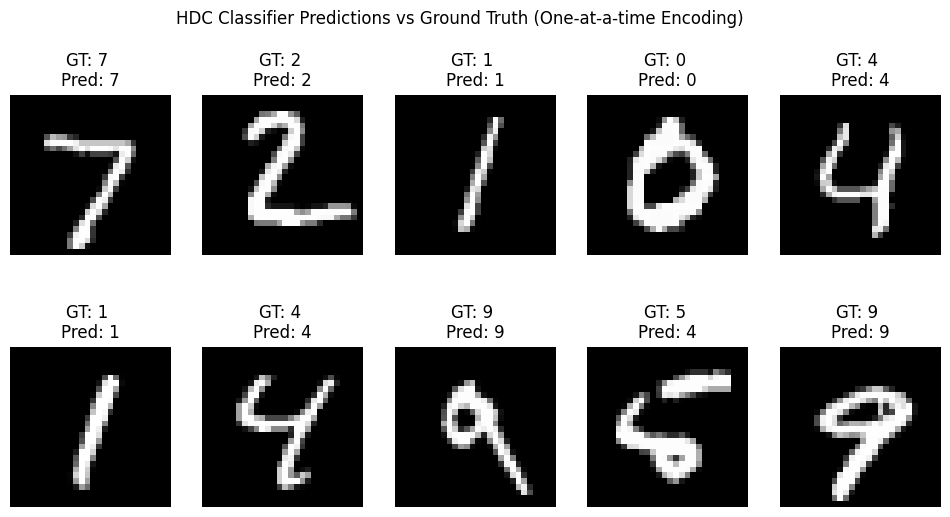

In [7]:
import matplotlib.pyplot as plt

# Get 10 test samples (batch size = 1, so loop naturally)
test_iter = iter(test_ld)

images, labels, predictions = [], [], []

for _ in range(10):
    img, lbl = next(test_iter)  # img shape: [1, 1, 28, 28]
    img = img.to(device)
    
    # Encode the sample with HDC encoder (one at a time)
    sample_hv = encode(img)  
    
    # Compute similarity between this hypervector and class centroids
    outputs = model(sample_hv, dot=True)
    
    # Predicted label = class with highest similarity
    _, pred = torch.max(outputs, dim=1)
    
    # Store results for visualization
    images.append(img.squeeze().cpu())
    labels.append(lbl.item())
    predictions.append(pred.item())

# --- Visualization ---
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.title(f"GT: {labels[i]} \nPred: {predictions[i]}")
    plt.axis("off")

plt.suptitle("HDC Classifier Predictions vs Ground Truth (One-at-a-time Encoding)")
plt.show()